# Train Food Recognition Model

In [1]:
LMDB_TRAIN_FILEPATH = "/mnt/data_ssd/lmdb/seefood_train_data_efficientnet_b3"
LMDB_TEST_FILEPATH = "/mnt/data_ssd/lmdb/seefood_test_data_efficientnet_b3"
LMDB_FLICKR30K_FILEPATH = "/mnt/data_ssd/lmdb/flickr_data_efficientnet_b3"

## Imports and Utilities

In [2]:
%load_ext lab_black

In [3]:
%load_ext autoreload
%autoreload 2

In [62]:
import logging
from joblib import dump, load
from datetime import datetime

from seefood.plotting import plot_interactive_scatter
from seefood.data import LMDBDataset
from seefood.features import EfficientNetFeatureExtractor
from seefood.model import food_recognition_model

from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.plotting import show

import torch
import umap
import numpy as np
import pandas as pd
import optuna

In [5]:
output_notebook()

Loading BokehJS ...

In [6]:
logging.basicConfig(
    format=("[%(funcName)s:%(lineno)d] - %(message)s"), level=logging.INFO
)

## Load Data

In [7]:
dataloader_train = torch.utils.data.DataLoader(
    LMDBDataset(LMDB_TRAIN_FILEPATH), batch_size=40000, shuffle=False, num_workers=0,
)

In [8]:
image_paths_train, X_train, _ = next(iter(dataloader_train))
image_paths_train[0], len(image_paths_train)

('/mnt/data_ssd/datasets/sparkrecipes/323873/000009', 40000)

In [9]:
dataloader_eval = torch.utils.data.DataLoader(
    LMDBDataset(LMDB_FLICKR30K_FILEPATH),
    batch_size=20000,
    shuffle=False,
    num_workers=0,
)

In [10]:
image_paths_eval, X_eval, _ = next(iter(dataloader_eval))
image_paths_eval[0], len(image_paths_eval)

('/mnt/data_ssd/datasets/flickr30k/7589467042.jpg', 20000)

## Tune Hyperparameters

In [43]:
def objective(trial):
    covariance_type = trial.suggest_categorical(
        "model__covariance_type", ["full", "tied", "diag", "spherical"]
    )
    pca_n_components = trial.suggest_int("pca__n_components", 128, X_train[0].shape[0])
    pca_whiten = trial.suggest_categorical("pca__whiten", [True, False])
    gmm_n_components = trial.suggest_int("model__n_components", 1, 24)

    pipe = (
        food_recognition_model()
        .set_params(
            pca__n_components=pca_n_components,
            pca__whiten=pca_whiten,
            model__covariance_type=covariance_type,
            model__n_components=gmm_n_components,
        )
        .fit(X_train)
    )

    feature_transform = pipe[:-1]
    model = pipe[-1]

    return model.bic(feature_transform.fit_transform(X_train))

In [44]:
study = optuna.create_study()

In [45]:
study.optimize(objective, n_trials=3)

/home/mike/.cache/pypoetry/virtualenvs/seefood-nC6BBDGh-py3.8/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[default_log_callback:35] - [StandardScaler(copy=True, with_mean=True, with_std=True)] shape=(40000, 1536) time=1s
[default_log_callback:35] - [PCA(copy=True, iterated_power='auto', n_components=1135, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)] shape=(40000, 1135) time=19s
[fit:80] - [PCA] explained variance mean: 0.0008255127968051079, std: 0.0015184103733464054
/home/mike/.cache/pypoetry/virtualenvs/seefood-nC6BBDGh-py3.8/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[default_log_callback:35] - [PrintPreprocessStats(p

In [46]:
study.best_params

{'model__covariance_type': 'tied',
 'pca__n_components': 191,
 'pca__whiten': True,
 'model__n_components': 21}

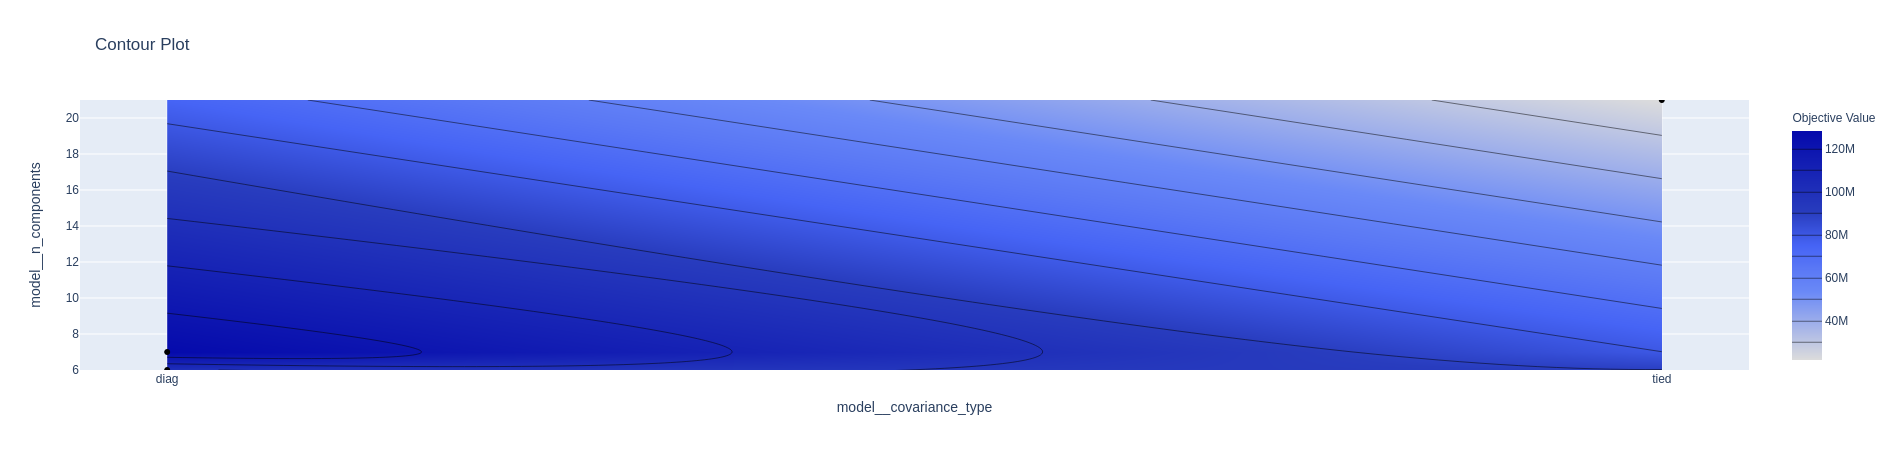

In [47]:
optuna.visualization.plot_contour(
    study, params=["model__covariance_type", "model__n_components"]
)

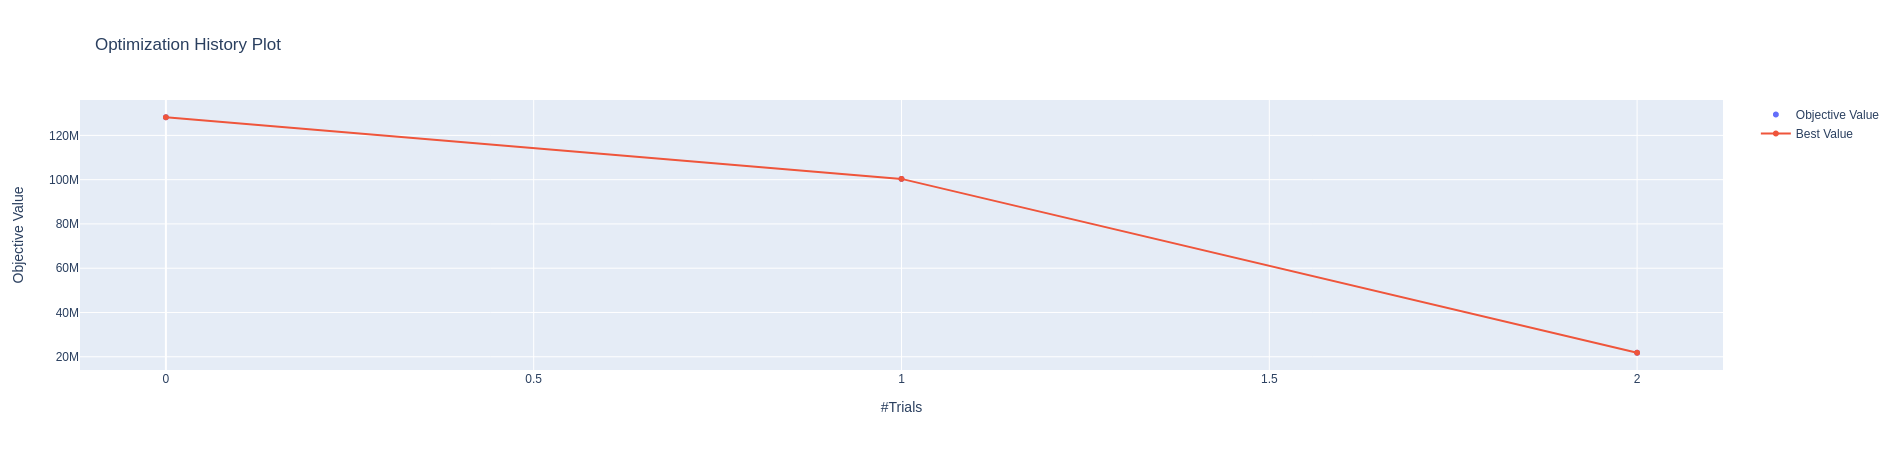

In [48]:
optuna.visualization.plot_optimization_history(study)

In [49]:
optuna.visualization.plot_parallel_coordinate(
    study, params=["model__covariance_type", "model__n_components"]
)

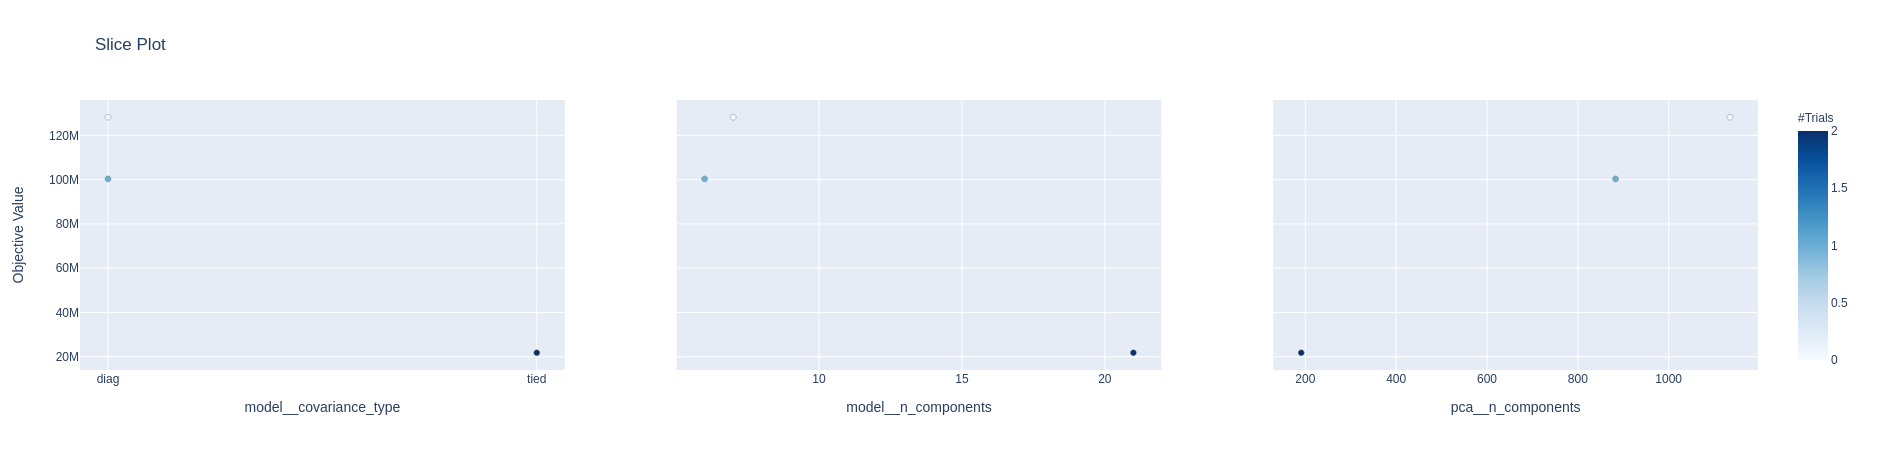

In [51]:
optuna.visualization.plot_slice(
    study, params=["model__covariance_type", "model__n_components", "pca__n_components"]
)

## Train Final Model

In [52]:
model = food_recognition_model().set_params(**study.best_params).fit(X_train)

/home/mike/.cache/pypoetry/virtualenvs/seefood-nC6BBDGh-py3.8/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[default_log_callback:35] - [StandardScaler(copy=True, with_mean=True, with_std=True)] shape=(40000, 1536) time=0s
[default_log_callback:35] - [PCA(copy=True, iterated_power='auto', n_components=191, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)] shape=(40000, 191) time=3s
[fit:80] - [PCA] explained variance mean: 0.002977518404997885, std: 0.002788796345026012
/home/mike/.cache/pypoetry/virtualenvs/seefood-nC6BBDGh-py3.8/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[default_log_callback:35] - [PrintPreprocessStats(pca=No

## Visualize Results

In [59]:
X = np.concatenate([X_train, X_eval])
X.shape

(60000, 1536)

In [54]:
umap_mapper = umap.UMAP(
    n_components=2, n_neighbors=5, min_dist=0.01, metric="cosine"
).fit(X)

In [55]:
def extract_path_suffix(image_paths):
    return [p[len("(/mnt/data_ssd/datasets/") - 1 :] for p in image_paths]

In [56]:
all_path_suffixes = extract_path_suffix(image_paths_train) + extract_path_suffix(
    image_paths_eval
)
all_path_suffixes[0]

'sparkrecipes/323873/000009'

In [57]:
img_urls = pd.Series(all_path_suffixes).map(
    lambda path: f"http://localhost:8080/{path}"
)
scores = model.score_samples(X)
labels = ["blue"] * len(image_paths_train) + ["red"] * len(image_paths_eval)

In [58]:
gmm_score_fig = plot_interactive_scatter(
    umap_mapper.embedding_, img_urls, values=scores
)
class_fig = plot_interactive_scatter(umap_mapper.embedding_, img_urls, labels=labels)

show(row(gmm_score_fig, class_fig))

## Persist Model

In [66]:
!mkdir -p models

In [67]:
dump(model, f'models/food_recognition_{datetime.now().strftime("%Y%m%d")}.joblib')

['models/food_recognition_20200531.joblib']

In [70]:
!gsutil cp models/*.joblib gs://seefood-models/

Copying file://models/food_recognition_20200531.joblib [Content-Type=application/octet-stream]...
- [1 files][  3.2 MiB/  3.2 MiB]  175.8 KiB/s                                   
Operation completed over 1 objects/3.2 MiB.                                      
